In [12]:
#!pip install xarray netcdf4 matplotlib numpy
#!pip install xarray numpy matplotlib netcdf4 glob2 pandas

In [1]:
#1. Global methane levels from 2002
#导入必要的库并设置绘图风格
import xarray as xr   # 用于处理 NetCDF (.nc) 数据
import numpy as np    # 用于数值计算
import matplotlib.pyplot as plt # 用于绘图

# 绘图设置
# 设置中文字体，确保中文标题能正常显示
# Windows 用户请尝试 'SimHei' 或 'Microsoft YaHei'
# Mac 用户请尝试 'Arial Unicode MS' 或 'Heiti TC'
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示为方块的问题

#图片清晰度
plt.rcParams['figure.dpi'] = 120 


In [13]:
#加载数据、清洗异常值并转换单位
# 定义文件名 (请确保文件在当前目录下)
file_name = '200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc'

try:
    # 打开数据集
    ds = xr.open_dataset(file_name)
    
    #步骤 A: 数据清洗 (去除 1e20 填充值)
    # 原始数据中，无效值被填充为 1e20 (即 10的20次方)。
    # 正常的甲烷摩尔分数非常小 (约 0.0000018)，所以我们过滤掉所有大于 1.0 的值。
    # .where() 会把不满足条件的数值变成 NaN (空值)，计算平均时会自动忽略。
    ds['xch4'] = ds['xch4'].where(ds['xch4'] < 1.0)
    
    # 步骤 B: 单位转换 (Mole Fraction -> ppb)
    # 题目要求单位是 ppb (parts per billion，十亿分之一)
    # 原始数据是无量纲的摩尔分数，需要乘以 10^9
    ds['xch4'] = ds['xch4'] * 1e9

    print("数据加载及预处理成功！")
    
    # 检查数据范围 
    # 正常的甲烷浓度应该在 1600 到 2000 ppb 之间
    min_val = ds['xch4'].min().item()
    max_val = ds['xch4'].max().item()
    print(f"数据范围检查: {min_val:.2f} ppb 到 {max_val:.2f} ppb")
    
    if max_val > 10000:
        print(" 警告：数据中似乎仍包含异常大值，请检查清洗逻辑。")
    else:
        print("数据范围正常。")

except FileNotFoundError:
    print(f" 错误：找不到文件 '{file_name}'。请检查文件名或路径。")

数据加载及预处理成功！
数据范围检查: 1566.99 ppb 到 1999.48 ppb
数据范围正常。


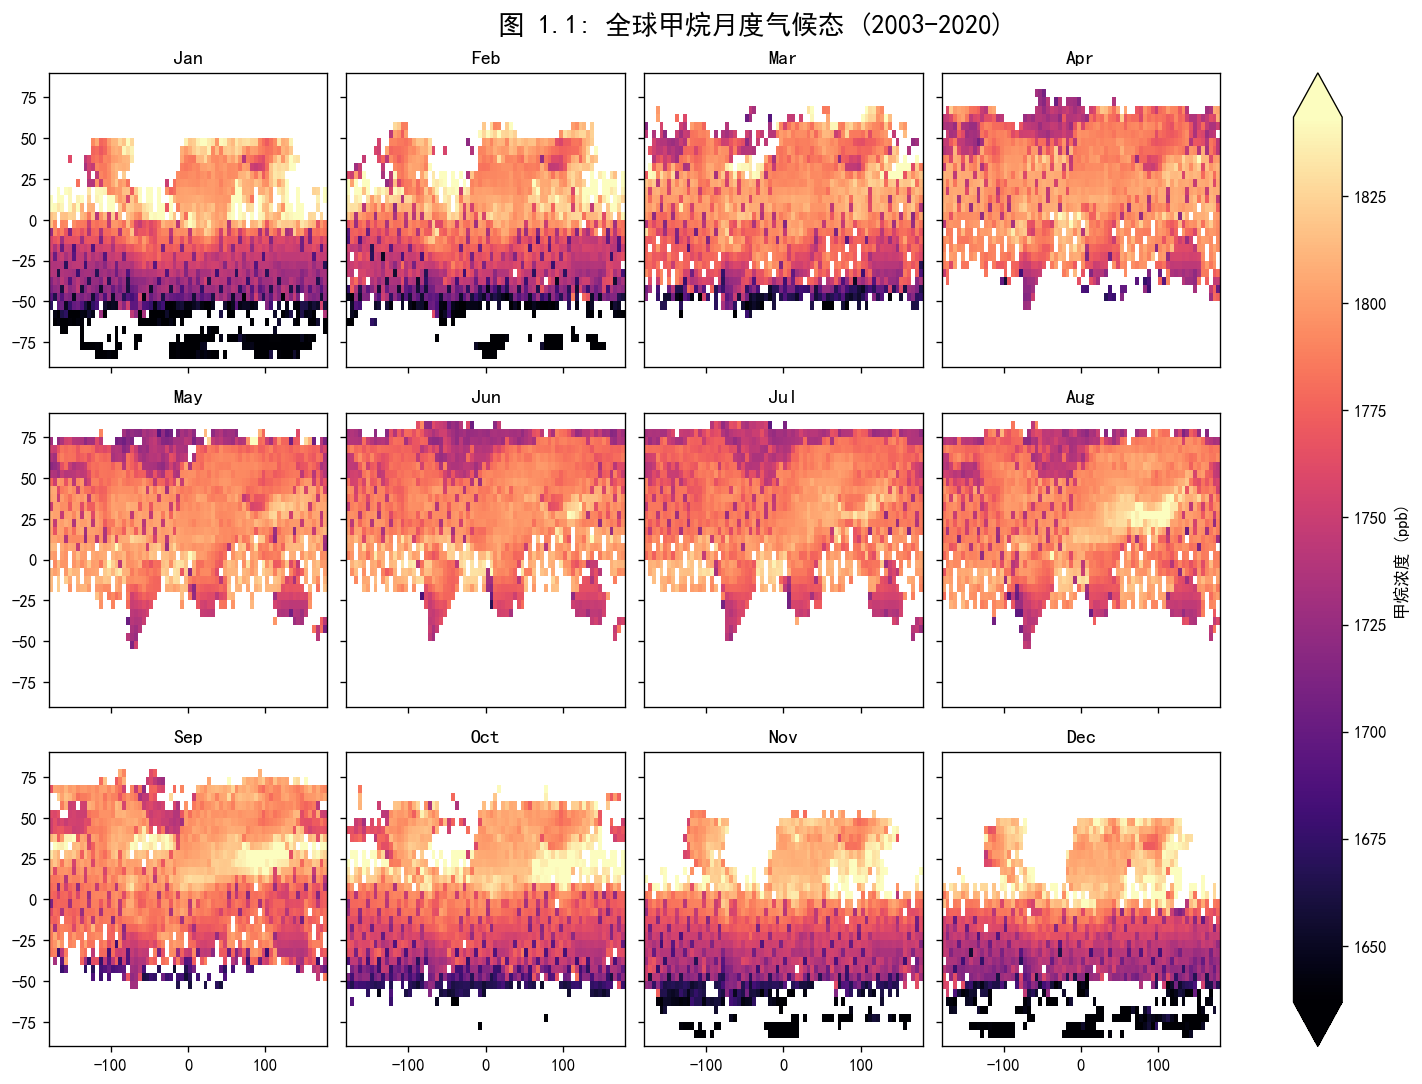

In [3]:
#1.1 [5 points] Compute methane climatology for each month, and plot your results in 12 panels.
#任务 1.1: 计算并绘制每月甲烷气候态

# 1. 计算气候态 (按月份分组求平均)
# 结果维度: (month: 12, lat: 36, lon: 72)
monthly_climatology = ds['xch4'].groupby('time.month').mean(dim='time')

# 2. 绘图
# 使用 'magma' 色阶模仿 NASA 风格 (黑-红-黄-白)，对比度高
g = monthly_climatology.plot(
    col='month',       # 按月份分列
    col_wrap=4,        # 每行 4 个图
    cmap='magma',      # 色阶：Magma (类似岩浆，很适合展示浓度)
    robust=True,       # 智能去除极值对颜色的干扰
    cbar_kwargs={'label': '甲烷浓度 (ppb)'} # 颜色条标签
)

# 3. 美化图表
# 设置总标题
g.fig.suptitle('图 1.1: 全球甲烷月度气候态 (2003-2020)', fontsize=16, y=1.02, fontweight='bold')

# 将子图标题从数字改为英文月份
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i, ax in enumerate(g.axs.flat):
    if i < 12:
        ax.set_title(month_names[i])
        # 去掉多余的经纬度标签，使图表更整洁
        ax.set_xlabel('')
        ax.set_ylabel('')

plt.show()

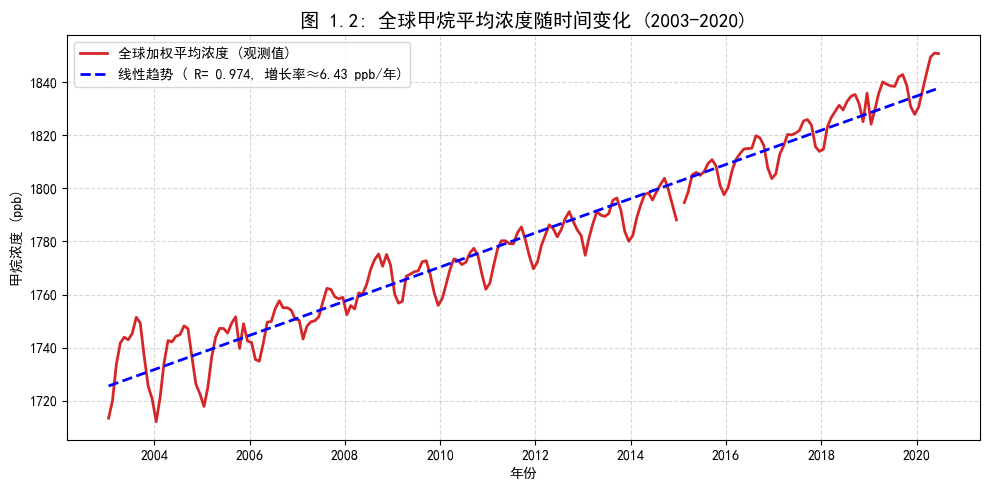

1.2 结果分析
1.长期趋势: 数据显示出极其显著的线性增长趋势，相关系数 R 高达 0.9744（接近 1.0），表明增长非常持续且稳定。
2.平均增长率: 根据线性拟合，2003-2020 年间全球甲烷浓度平均每年增加约 6.43 ppb。
3.数值变化: 浓度从 2003 年初的约 1713.5 ppb 上升至 2020 年中的约 1850.7 ppb。
4.季节性特征: 在上升趋势之上，依然可以观察到规律的年内季节性波动（曲线的锯齿状），这通常由湿地排放和大气氧化能力的季节性变化驱动。


In [14]:
#1.2 [5 points] Plot globally-averaged methane from 2003-01 to 2020-06 as a time series. Describe your results.
#Check your plot with this one.
#任务 1.2: 全球平均甲烷时间序列 (加权平均)

# 1. 创建面积权重
# 地球是球体，高纬度(靠近极地)的网格实际面积小，低纬度(赤道)面积大。
# 权重 = cos(纬度)
weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

# 2. 计算加权平均
# 先用 .weighted(weights) 加权，再对 lat 和 lon 维度求平均
global_mean_weighted = ds['xch4'].weighted(weights).mean(dim=['lat', 'lon'])

# 3. 准备线性回归数据
# 获取数值形式的数据和时间
y_data = global_mean_weighted.values
x_time = global_mean_weighted.time.values

# 将时间转换为数值（自第一个时间点起的天数），以便进行线性拟合
x_numeric = (x_time - x_time[0]) / np.timedelta64(1, 'D')

# 清洗数据 (去除 NaN 以防万一)
valid_mask = ~np.isnan(y_data)
x_clean = x_numeric[valid_mask]
y_clean = y_data[valid_mask]

# 4. 计算线性回归与相关系数
if len(x_clean) > 0:
    # 线性拟合 (y = kx + b)
    slope, intercept = np.polyfit(x_clean, y_clean, 1)
    y_trend = slope * x_numeric + intercept
    
    # 计算皮尔逊相关系数 R
    r_matrix = np.corrcoef(x_clean, y_clean)
    r_value = r_matrix[0, 1]
    
    # 计算平均增长率 (ppb/年)
    # slope 是 ppb/天，乘以 365.25 得到 ppb/年
    growth_rate = slope * 365.25


# 5. 绘图
plt.figure(figsize=(10, 5))

# (A) 绘制数据曲线
global_mean_weighted.plot(
    linewidth=2, 
    color='#d62728', # 砖红色
    label='全球加权平均浓度 (观测值)'
)

# (B) 绘制线性趋势线
if len(x_clean) > 0:
    plt.plot(x_time, y_trend, color='blue', linestyle='--', linewidth=2, 
             label=f'线性趋势 ( R= {r_value:.3f}, 增长率≈{growth_rate:.2f} ppb/年)')

# 6. 设置标签与网格
plt.title('图 1.2: 全球甲烷平均浓度随时间变化 (2003-2020)', fontsize=14, fontweight='bold')
plt.xlabel('年份')
plt.ylabel('甲烷浓度 (ppb)')
plt.grid(True, linestyle='--', alpha=0.5) # 虚线网格
plt.legend()

plt.tight_layout()
plt.show()

# 7. 详细结果描述
print("1.2 结果分析")
print(f"1.长期趋势: 数据显示出极其显著的线性增长趋势，相关系数 R 高达 {r_value:.4f}（接近 1.0），表明增长非常持续且稳定。")
print(f"2.平均增长率: 根据线性拟合，2003-2020 年间全球甲烷浓度平均每年增加约 {growth_rate:.2f} ppb。")
print(f"3.数值变化: 浓度从 2003 年初的约 {y_clean[0]:.1f} ppb 上升至 2020 年中的约 {y_clean[-1]:.1f} ppb。")
print("4.季节性特征: 在上升趋势之上，依然可以观察到规律的年内季节性波动（曲线的锯齿状），这通常由湿地排放和大气氧化能力的季节性变化驱动。")

检测到经度格式为 -180~180，目标经度为: -150°


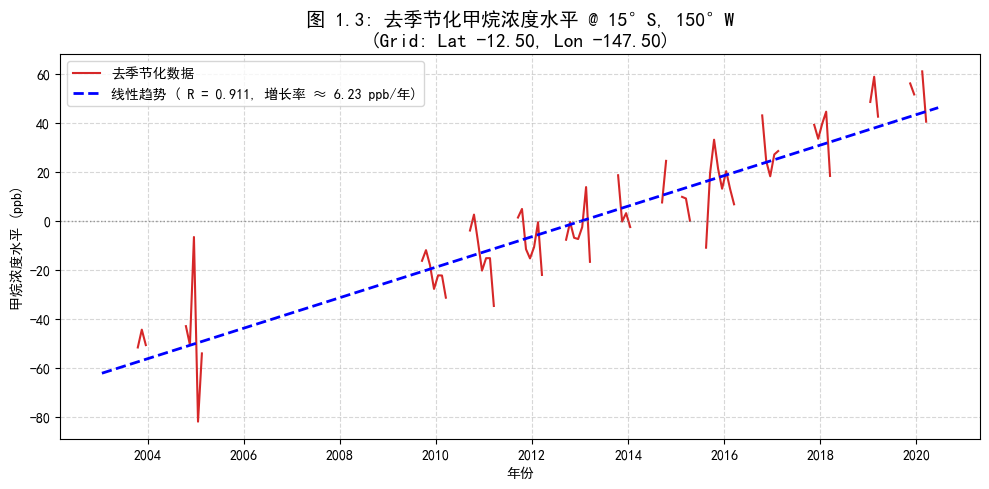

1.3 结果
如图 1.3 所示，这是在 [-15°S, -150°E] 附近格点的去季节化甲烷时间序列。
1.长期趋势与年际变率: 曲线在 0 刻度线附近的波动揭示了非季节性的变化。
2.强正相关性: 添加的线性趋势线显示 R = 0.91，这证实了甲烷浓度随时间呈现极强的正相关增长趋势。
3.科学解释: 这种非季节性的波动（例如某些年份的显著正距平），可能与厄尔尼诺-南方涛动 (ENSO) 等年际气候现象，或该区域特定的传输与排放异常有关。


In [17]:
#1.3 [5 points] Plot deseasonalized methane levels at point [15°S, 150°W] from 2003-01 to 2020-06 as a time series. 
# 绘制 2003-01 至 2004 年 [15°S, 150°W] 点的去季节性甲烷浓度图 2020-06 作为时间序列进行分析

# 1. 坐标转换逻辑
# 目标: 15°S, 150°W
target_lat = -15 

# 检查数据的经度格式是 -180~180 还是 0~360
# 150°W 在 0~360 格式下是 360 - 150 = 210
if ds.lon.max() > 180:
    target_lon = 360 - 150 # = 210
    print(f"检测到经度格式为 0~360，目标经度转换为: {target_lon}°E")
else:
    target_lon = -150
    print(f"检测到经度格式为 -180~180，目标经度为: {target_lon}°")

# 2. 选取该点的原始数据
# method='nearest' 会自动寻找距离最近的网格点
point_data = ds['xch4'].sel(lat=target_lat, lon=target_lon, method='nearest')

# 3. 计算去季节化 (Deseasonalized)
# 逻辑：原始数据 - 该月的多年平均值
climatology = point_data.groupby('time.month').mean('time')
deseasonalized_data = point_data.groupby('time.month') - climatology

# 4. 准备线性回归数据
# 获取数值形式的数据和时间
y_data = deseasonalized_data.values
x_time = deseasonalized_data.time.values

# 将时间转换为数值（自第一个时间点起的天数），以便进行线性拟合
x_numeric = (x_time - x_time[0]) / np.timedelta64(1, 'D')

# 清洗数据 (去除 NaN)
valid_mask = ~np.isnan(y_data)
x_clean = x_numeric[valid_mask]
y_clean = y_data[valid_mask]

# 5. 计算统计指标 (趋势与R值)
if len(x_clean) > 0:
    # 线性拟合 (y = kx + b)
    slope, intercept = np.polyfit(x_clean, y_clean, 1)
    y_trend = slope * x_numeric + intercept
    
    # 计算皮尔逊相关系数 R
    r_matrix = np.corrcoef(x_clean, y_clean)
    r_value = r_matrix[0, 1]
    
    # 计算年增长率 (ppb/year)
    growth_rate = slope * 365.25

# 6. 绘图 (应用统一配色)
plt.figure(figsize=(10, 5))

# (A) 绘制去季节化数据 (使用砖红色 #d62728，与 1.2 保持一致)
deseasonalized_data.plot(
    color='#d62728', 
    linewidth=1.5, 
    label='去季节化数据'
)

# (B) 绘制线性趋势线 (使用蓝色，与1.2 保持一致)
if len(x_clean) > 0:
    plt.plot(x_time, y_trend, color='blue', linestyle='--', linewidth=2, 
             label=f'线性趋势 ( R = {r_value:.3f}, 增长率 ≈ {growth_rate:.2f} ppb/年)')

# 添加 0 刻度参考线 (灰色虚线)
plt.axhline(0, color='gray', linestyle=':', alpha=0.8, linewidth=1)

# 获取实际选取的网格坐标用于标题
act_lat = float(point_data.lat)
act_lon = float(point_data.lon)

# 设置标题和标签
plt.title(f'图 1.3: 去季节化甲烷浓度水平 @ 15°S, 150°W\n(Grid: Lat {act_lat:.2f}, Lon {act_lon:.2f})', fontsize=14, fontweight='bold')
plt.xlabel('年份')
plt.ylabel('甲烷浓度水平 (ppb)')
plt.legend() # 显示图例
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 7. 详细结果描述
print("1.3 结果")
print(f"如图 1.3 所示，这是在 [{target_lat}°S, {target_lon}°E] 附近格点的去季节化甲烷时间序列。")
print("1.长期趋势与年际变率: 曲线在 0 刻度线附近的波动揭示了非季节性的变化。")
print(f"2.强正相关性: 添加的线性趋势线显示 R = {r_value:.2f}，这证实了甲烷浓度随时间呈现极强的正相关增长趋势。")
print("3.科学解释: 这种非季节性的波动（例如某些年份的显著正距平），可能与厄尔尼诺-南方涛动 (ENSO) 等年际气候现象，或该区域特定的传输与排放异常有关。")

In [6]:
#2. Niño 3.4 index
#导入库
import xarray as xr             # 处理 NetCDF 气象数据
import matplotlib.pyplot as plt # 绘图
import numpy as np              # 数学运算
import pandas as pd             # 处理时间数据

#绘图风格
plt.style.use('default') 


In [7]:
# 定义文件路径
file_path = 'NOAA_NCDC_ERSST_v3b_SST.nc'

try:
    # 加载 NetCDF 数据集
    ds = xr.open_dataset(file_path)
    print(f"成功加载文件: {file_path}")
    
    # 打印数据集信息，确认 lat/lon/time 的范围
    #发现 latitude 是从小到大排列的
    print(ds)
    
except FileNotFoundError:
    print(f"错误: 找不到文件 {file_path}")
    print("请确保 .nc 文件和本 Notebook 在同一个文件夹下")
    

成功加载文件: NOAA_NCDC_ERSST_v3b_SST.nc
<xarray.Dataset> Size: 44MB
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 356B -88.0 -86.0 -84.0 -82.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 5kB 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time, lat, lon) float32 44MB ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...


In [8]:
#2.1 计算 Niño 3.4 区域的月平均海表温度，并从海表温度时间序列中减去平均海表温度，得到海表温度异常值。

# 1. 定义 Niño 3.4 区域
# 注意：lat 是升序排列 (-88 到 88)
# 所以切片必须是从小到大: slice(-5, 5) 表示 5S 到 5N
lat_slice = slice(-5, 5)   
lon_slice = slice(190, 240) # 170W-120W 转换为 190E-240E

# 2. 截取数据并计算区域平均
# .sel() 选取区域, .mean() 对 lat 和 lon 维度求平均，得到时间序列
sst_nino34 = ds['sst'].sel(lat=lat_slice, lon=lon_slice)
sst_nino34_timeseries = sst_nino34.mean(dim=['lat', 'lon'])

# 3. 计算月平均气候态 (Climatology)
# 按月份分组 (1-12月)，对所有年份求平均
climatology = sst_nino34_timeseries.groupby('time.month').mean(dim='time')

# 4. 计算距平 (Anomalies)
# 原始数据 - 对应月份的气候态
anomalies = sst_nino34_timeseries.groupby('time.month') - climatology

# 简单检查一下计算结果的前几行，确保不是 NaN
print("距平数据计算完成。前5个数据点：")
print(anomalies.head())


距平数据计算完成。前5个数据点：
<xarray.DataArray 'sst' (time: 5)> Size: 40B
array([-0.31957817, -0.4685173 , -0.26815224, -0.18696594, -0.17759895])
Coordinates:
  * time     (time) datetime64[ns] 40B 1960-01-15 1960-02-15 ... 1960-05-15
    month    (time) int64 40B 1 2 3 4 5


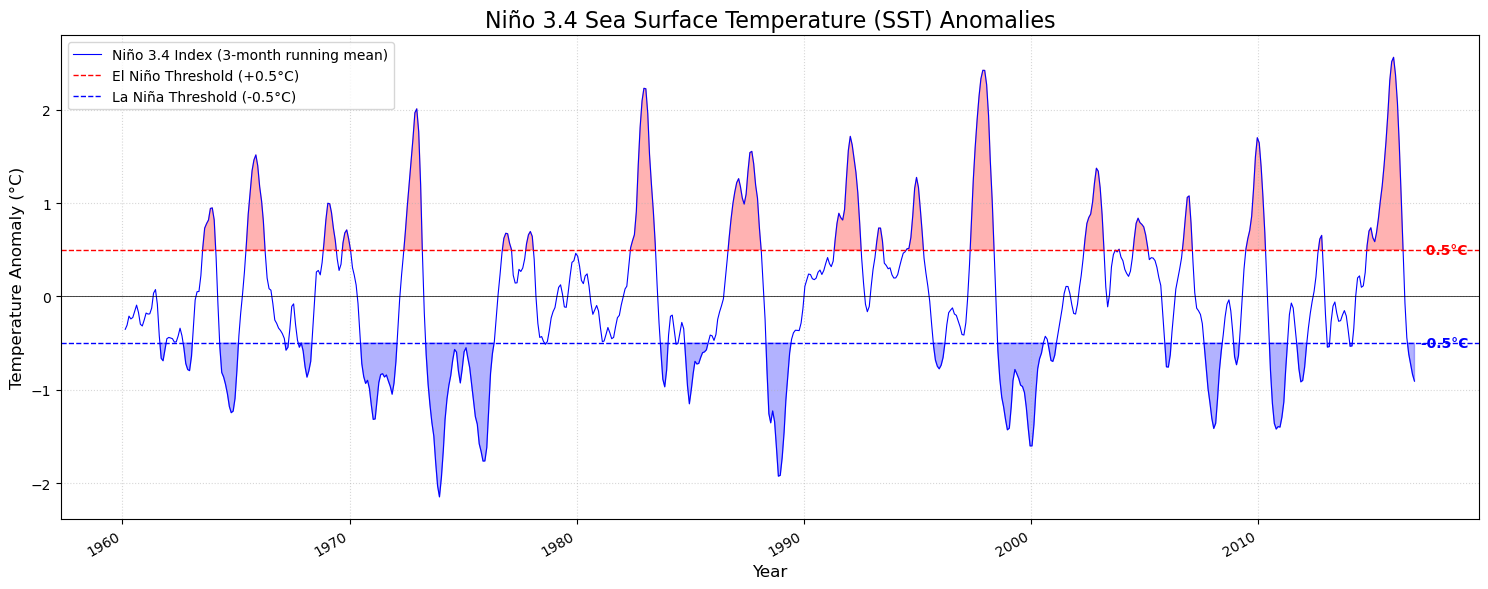

In [9]:
#2.1 将计算出的 Niño 3.4 可视化。应与例图类似

# 1. 计算 3 个月滑动平均
# center=True 表示窗口中心对齐
nino34_index = anomalies.rolling(time=3, center=True).mean()

# 2. 截取 1950 年之后的数据用于绘图 (根据题目参考图样式)
# 如果数据本身从1960开始，这个切片会自动适配
plot_data = nino34_index.sel(time=slice('1950-01-01', None))

# 3. 创建画布
plt.figure(figsize=(15, 6))

# 绘制主曲线
plt.plot(plot_data['time'], plot_data, 
         label='Niño 3.4 Index (3-month running mean)', 
         color='blue', linewidth=0.8)

# 4. 绘制参考线 (0度线, +0.5度线, -0.5度线)
plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
plt.axhline(0.5, color='red', linestyle='--', linewidth=1, label='El Niño Threshold (+0.5°C)')
plt.axhline(-0.5, color='blue', linestyle='--', linewidth=1, label='La Niña Threshold (-0.5°C)')

# 5. 添加颜色填充
# 提取数值用于 fill_between
times = plot_data['time'].values
values = plot_data.values

# 填充红色 (El Niño > 0.5)
plt.fill_between(times, values, 0.5, 
                 where=(values >= 0.5), 
                 color='red', alpha=0.3, interpolate=True)

# 填充蓝色 (La Niña < -0.5)
plt.fill_between(times, values, -0.5, 
                 where=(values <= -0.5), 
                 color='blue', alpha=0.3, interpolate=True)

# 6. 添加末尾的数值标注 (根据你的新需求)
last_date = times[-1] # 获取最后一个时间点作为 x 坐标
# 在 0.5 和 -0.5 的位置添加文字
plt.text(last_date, 0.5, '  0.5°C', color='red', va='center', fontweight='bold')
plt.text(last_date, -0.5, ' -0.5°C', color='blue', va='center', fontweight='bold')

# 7. 设置标题、标签和图例
plt.title('Niño 3.4 Sea Surface Temperature (SST) Anomalies', fontsize=16)
plt.ylabel('Temperature Anomaly (°C)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, linestyle=':', alpha=0.5)

# 自动调整时间轴标签格式
plt.gcf().autofmt_xdate()

# 显示图像
plt.tight_layout()
plt.show()

In [20]:
#3. Explore a netCDF dataset 探索 netCDF 数据集
#数据导入整合以及清洗有两版数据需要重组到一起
# 导入必要的库
import xarray as xr  # 用于读取和处理 netCDF 数据
import matplotlib.pyplot as plt  # 用于绘图
import numpy as np  # 用于数值计算
import glob  # 用于查找文件
import pandas as pd  # 导入 pandas 用于手动创建日期

# 指定一个中文字体列表，matplotlib 会依次尝试
# 'SimHei' (黑体) 和 'Microsoft YaHei' (微软雅黑) 是 Windows 上常见的中文字体
# 'Heiti TC' 或 'Arial Unicode MS' 可能在 Mac 或 Linux 上可用
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Heiti TC', 'Arial Unicode MS', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示为方块的问题

#1. 加载和探索数据 (合并) 

# 设置要加载的变量，'flux' 似乎是这个数据集的关键变量
VARIABLE_NAME = 'flux'
datasets_to_merge = []

# 1.1 加载 v1 数据 (2010-2012)
file_pattern_v1 = "CMSFluxFire_*_v1.nc4"
file_list_v1 = sorted(glob.glob(file_pattern_v1))

fixed_v1_datasets = [] # 创建一个空列表来存放已修复的数据集

if file_list_v1:
    print(f"找到了 {len(file_list_v1)} 个 v1 文件，将逐个打开并修复：")
    print("\n".join(file_list_v1))

    # 错误修复：我们不能用 open_mfdataset，因为它无法自动合并未解码的时间。
    # 我们必须逐个打开、修复时间，然后再合并。
    for file_path in file_list_v1:
        # 1. 逐个打开文件，不解码时间
        try:
            ds_single_v1 = xr.open_dataset(file_path, decode_times=False)
            print(f"\n正在处理 {file_path}...")

            # 2. 检查并手动修复 v1 time
            if 'months since' in ds_single_v1.time.attrs.get('units', ''):
                print("... 检测到 'months since' unit, 正在手动解码 time...")
                
                time_units = ds_single_v1.time.attrs['units']
                # 解析 'YYYY-MM-DD' 格式的起始日期
                start_date_str = time_units.split('since')[-1].strip().split('T')[0] # 移除 T00:00:00
                num_months = len(ds_single_v1.time)
                
                # 创建新的日期范围 (MS = Month Start)
                new_times = pd.date_range(start=start_date_str, periods=num_months, freq='MS') + pd.DateOffset(days=14)
                
                # 分配新坐标
                ds_single_v1 = ds_single_v1.assign_coords(time=new_times)
                print(f"... time 已成功解码为 {len(new_times)} 个时间点, 从 {new_times.min()} 到 {new_times.max()}")

                # 3. 添加到列表中
                fixed_v1_datasets.append(ds_single_v1)
            else:
                print(f"... 警告: {file_path} 中未找到 'months since' time unit，跳过此文件。")
        
        except Exception as e:
            print(f"处理 {file_path} 时出错: {e}")

    # 4. 如果列表不为空，则合并所有已修复的 v1 数据集
    if fixed_v1_datasets:
        print("\n... 正在合并所有已修复的 v1 数据集...")
        ds_v1 = xr.concat(fixed_v1_datasets, dim='time')
    
        # 关键步骤：重命名 v1 中的 'Fire' 变量为 'flux'，以便与 v2 统一
        if 'Fire' in ds_v1.data_vars:
            print("... 已将 v1 中的 'Fire' 变量重命名为 'flux'")
            ds_v1 = ds_v1.rename({'Fire': 'flux'})
            # 我们只保留 'flux' 变量，以避免与其他 v2 变量 (如 area) 冲突
            datasets_to_merge.append(ds_v1[VARIABLE_NAME])
        else:
            print("... v1 文件中未找到 'Fire' 变量，跳过 v1。")
    else:
        # 如果 fixed_v1_datasets 为空，也要打印 "未找到 v1 文件"
        print("... 未能成功加载任何 v1 数据。")

else:
    print("未找到 v1 文件。")

# 1.2 加载 v2 数据 (2013-2016)
file_pattern_v2 = "CMS_Flux_Fire_*_v2.nc"
file_list_v2 = sorted(glob.glob(file_pattern_v2))

fixed_v2_datasets = [] # 创建一个空列表来存放已修复的 v2 数据集

if file_list_v2:
    print(f"找到了 {len(file_list_v2)} 个 v2 文件，将逐个打开并修复：")
    print("\n".join(file_list_v2))

    # 错误修复：v2 同样有 'months since' 问题，所以我们使用与 v1 相同的逻辑
    for file_path in file_list_v2:
        # 1. 逐个打开文件，不解码时间
        try:
            ds_single_v2 = xr.open_dataset(file_path, decode_times=False)
            print(f"\n正在处理 {file_path}...")

            # 2. 检查并手动修复 v2 time
            if 'months since' in ds_single_v2.time.attrs.get('units', ''):
                print("... 检测到 'months since' unit, 正在手动解码 time...")
                
                time_units = ds_single_v2.time.attrs['units']
                # 解析 'YYYY-MM-DD' 格式的起始日期
                start_date_str = time_units.split('since')[-1].strip().split('T')[0] # 移除 T00:00:00
                num_months = len(ds_single_v2.time)
                
                # 创建新的日期范围
                new_times = pd.date_range(start=start_date_str, periods=num_months, freq='MS') + pd.DateOffset(days=14)
                
                # 分配新坐标
                ds_single_v2 = ds_single_v2.assign_coords(time=new_times)
                print(f"... time 已成功解码为 {len(new_times)} 个时间点, 从 {new_times.min()} 到 {new_times.max()}")

                # 3. 添加到列表中
                fixed_v2_datasets.append(ds_single_v2)
            else:
                print(f"... 警告: {file_path} 中未找到 'months since' time unit，跳过此文件。")
        
        except Exception as e:
            print(f"处理 {file_path} 时出错: {e}")

    # 4. 如果列表不为空，则合并所有已修复的 v2 数据集
    if fixed_v2_datasets:
        print("\n... 正在合并所有已修复的 v2 数据集...")
        ds_v2 = xr.concat(fixed_v2_datasets, dim='time')
    
        if VARIABLE_NAME in ds_v2.data_vars:
            # v2 文件中有很多变量 (flux, fluxunc, area...)，我们只保留 'flux'
            datasets_to_merge.append(ds_v2[VARIABLE_NAME])
        else:
            print("... v2 文件中未找到 'flux' 变量，跳过 v2。")
    else:
        print("... 未能成功加载任何 v2 数据。")
else:
    print("未找到 v2 文件。")


# 1.3 合并 v1 和 v2
if not datasets_to_merge:
    print(f"错误：在当前目录下找不到 v1 或 v2 文件。请确保文件与本脚本在同一目录。")
    # exit() # 如果在真实脚本中，你可能想在这里退出
    # 为了演示，创建一个空对象
    ds = xr.Dataset()
else:
    print(f"\n正在合并 {len(datasets_to_merge)} 个数据块 (v1 和 v2)...")
    # xr.concat 将 v1 的 'flux' (DataArray) 和 v2 的 'flux' (DataArray) 合并
    flux_combined = xr.concat(datasets_to_merge, dim='time')
    
    # 按时间排序，确保 2010-2016 顺序正确
    flux_combined = flux_combined.sortby('time')
    
    # 将合并后的 DataArray 转换回 Dataset，以便脚本的其余部分可以工作
    ds = flux_combined.to_dataset()
    
    # 修复单位：合并可能会丢失 'units' 属性。我们手动添加它。
    # 你应该在数据文档中检查 v1 'Fire' 和 v2 'flux' 的单位是否一致！
    if 'units' not in ds[VARIABLE_NAME].attrs:
        print("... 合并后 'units' 属性丢失，正在手动添加一个假定单位。")
        ds[VARIABLE_NAME].attrs['units'] = 'g C m-2 month-1 (assumed)'

# --- 1.4 数据清洗与质量控制 (Data Cleaning) ---
print("\n--- 1.4 数据清洗与检查 ---")

# 1. 检查 NaN (缺失值)
# .isnull().sum() 会计算整个数组中 NaN 的个数
nan_count = ds[VARIABLE_NAME].isnull().sum().values
total_count = ds[VARIABLE_NAME].size
print(f"数据总量: {total_count}")
print(f"缺失值 (NaN) 数量: {nan_count} ({nan_count/total_count*100:.2f}%)")

# 策略：对于火烧数据，NaN 通常意味着无火灾 (0排放)。
# 如果不处理，求和时可能会出现问题，或者导致不必要的空白。
# 我们在这里将 NaN 填充为 0。
if nan_count > 0:
    print("正在将缺失值 (NaN) 填充为 0 (假设无火灾)...")
    ds[VARIABLE_NAME] = ds[VARIABLE_NAME].fillna(0.0)

# 2. 检查 Inf (无穷大)
# 有时候计算错误会导致无穷大，需要替换为 NaN (或者在这里也是 0)
# 使用 xr.where 检查是否为 inf
inf_count = np.isinf(ds[VARIABLE_NAME]).sum().values
if inf_count > 0:
    print(f"发现 {inf_count} 个无穷大值 (Inf)，正在替换为 0...")
    ds[VARIABLE_NAME] = ds[VARIABLE_NAME].where(~np.isinf(ds[VARIABLE_NAME]), 0.0)
else:
    print("未发现无穷大值 (Inf)。")

# 3. 检查负值 (对于火烧碳通量，负值通常没有物理意义，除非表示碳汇)
# 这里我们只是统计，不一定删除，取决于你的物理知识
negative_count = (ds[VARIABLE_NAME] < 0).sum().values
if negative_count > 0:
    print(f"警告: 发现 {negative_count} 个负值。请确认这是否符合物理意义。")
    # 如果确定负值是错误的，可以取消下面这行的注释来过滤掉它们：
    # ds[VARIABLE_NAME] = ds[VARIABLE_NAME].where(ds[VARIABLE_NAME] >= 0)
else:
    print("未发现负值。")

# 4. 简单的统计概览 (检查数量级一致性)
print("\n数据统计概览:")
print(f"最小值: {ds[VARIABLE_NAME].min().values}")
print(f"最大值: {ds[VARIABLE_NAME].max().values}")
print(f"平均值: {ds[VARIABLE_NAME].mean().values}")

print("------------------------")


# 打印数据集的摘要信息，了解它包含哪些变量和维度
print("\n--- 合并后的数据集信息 (2010-2016) ---")
print(ds)


找到了 3 个 v1 文件，将逐个打开并修复：
CMSFluxFire_2010_v1.nc4
CMSFluxFire_2011_v1.nc4
CMSFluxFire_2012_v1.nc4

正在处理 CMSFluxFire_2010_v1.nc4...
... 检测到 'months since' unit, 正在手动解码 time...
... time 已成功解码为 12 个时间点, 从 2010-01-15 00:00:00 到 2010-12-15 00:00:00

正在处理 CMSFluxFire_2011_v1.nc4...
... 检测到 'months since' unit, 正在手动解码 time...
... time 已成功解码为 12 个时间点, 从 2011-01-15 00:00:00 到 2011-12-15 00:00:00

正在处理 CMSFluxFire_2012_v1.nc4...
... 检测到 'months since' unit, 正在手动解码 time...
... time 已成功解码为 12 个时间点, 从 2012-01-15 00:00:00 到 2012-12-15 00:00:00

... 正在合并所有已修复的 v1 数据集...
... 已将 v1 中的 'Fire' 变量重命名为 'flux'
找到了 4 个 v2 文件，将逐个打开并修复：
CMS_Flux_Fire_2013_v2.nc
CMS_Flux_Fire_2014_v2.nc
CMS_Flux_Fire_2015_v2.nc
CMS_Flux_Fire_2016_v2.nc

正在处理 CMS_Flux_Fire_2013_v2.nc...
... 检测到 'months since' unit, 正在手动解码 time...
... time 已成功解码为 12 个时间点, 从 2013-01-15 00:00:00 到 2013-12-15 00:00:00

正在处理 CMS_Flux_Fire_2014_v2.nc...
... 检测到 'months since' unit, 正在手动解码 time...
... time 已成功解码为 12 个时间点, 从 2014-01-15 00:00:00 到 2014-12-

3.1 图像已保存为 'task_3.1_flux_anomaly_timeseries_2010-2016.png'


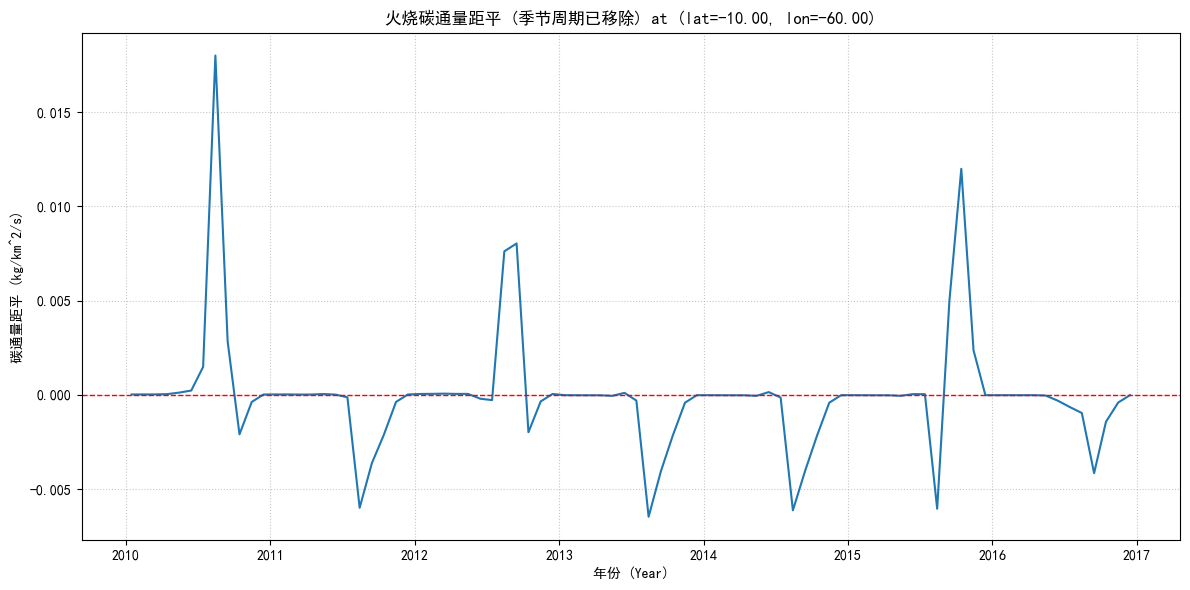

In [21]:
#3.1 [5 分] 绘制去除月度季节性周期后的某个变量的时间序列图。

# 选择一个特定地点（纬度/经度）的时间序列
# 我们选择亚马孙雨林中的一个点 (火灾频发区)
lat_point = -10.0  # 南纬 10 度
lon_point = -60.0  # 西经 60 度 (你的数据经度范围可能是 -180 到 180)
# 使用 .sel() 方法，并选择 'nearest'（最近）的点
flux_ts = ds[VARIABLE_NAME].sel(lat=lat_point, lon=lon_point, method='nearest')

# 计算月平均气候态（Seasonal Cycle / Climatology）
# 'time.month' 会自动提取每个时间点所在的月份
# .groupby() 按月份分组，然后 .mean() 计算每个月的平均值
climatology = flux_ts.groupby('time.month').mean(dim='time')

#计算距平（Anomaly）
# 距平 = 原始值 - 对应月份的气候态均值
anomaly = flux_ts.groupby('time.month') - climatology

#绘制距平时间序列
plt.figure(figsize=(12, 6))  # 创建一个新图窗，设置大小
anomaly.plot()  # xarray 自动绘制带标签的图像
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # 添加一条 y=0 的参考红线
plt.title(f"火烧碳通量距平 (季节周期已移除) at (lat={lat_point:.2f}, lon={lon_point:.2f})")
plt.xlabel("年份 (Year)")
plt.ylabel(f"碳通量距平 ({ds[VARIABLE_NAME].units})") # 自动获取单位
plt.grid(True, linestyle=':', alpha=0.7)  # 添加网格线
plt.tight_layout()  # 自动调整布局
plt.savefig("task_3.1_flux_anomaly_timeseries_2010-2016.png")  # 保存图像
print("3.1 图像已保存为 'task_3.1_flux_anomaly_timeseries_2010-2016.png'")
# plt.show() # 如果你希望在脚本运行时立即显示图像，请取消本行注释



3.2：绘制至少 5 个不同的图
3.2 图像已保存为 'task_3.2_multi_flux_plots_2010-2016.png'


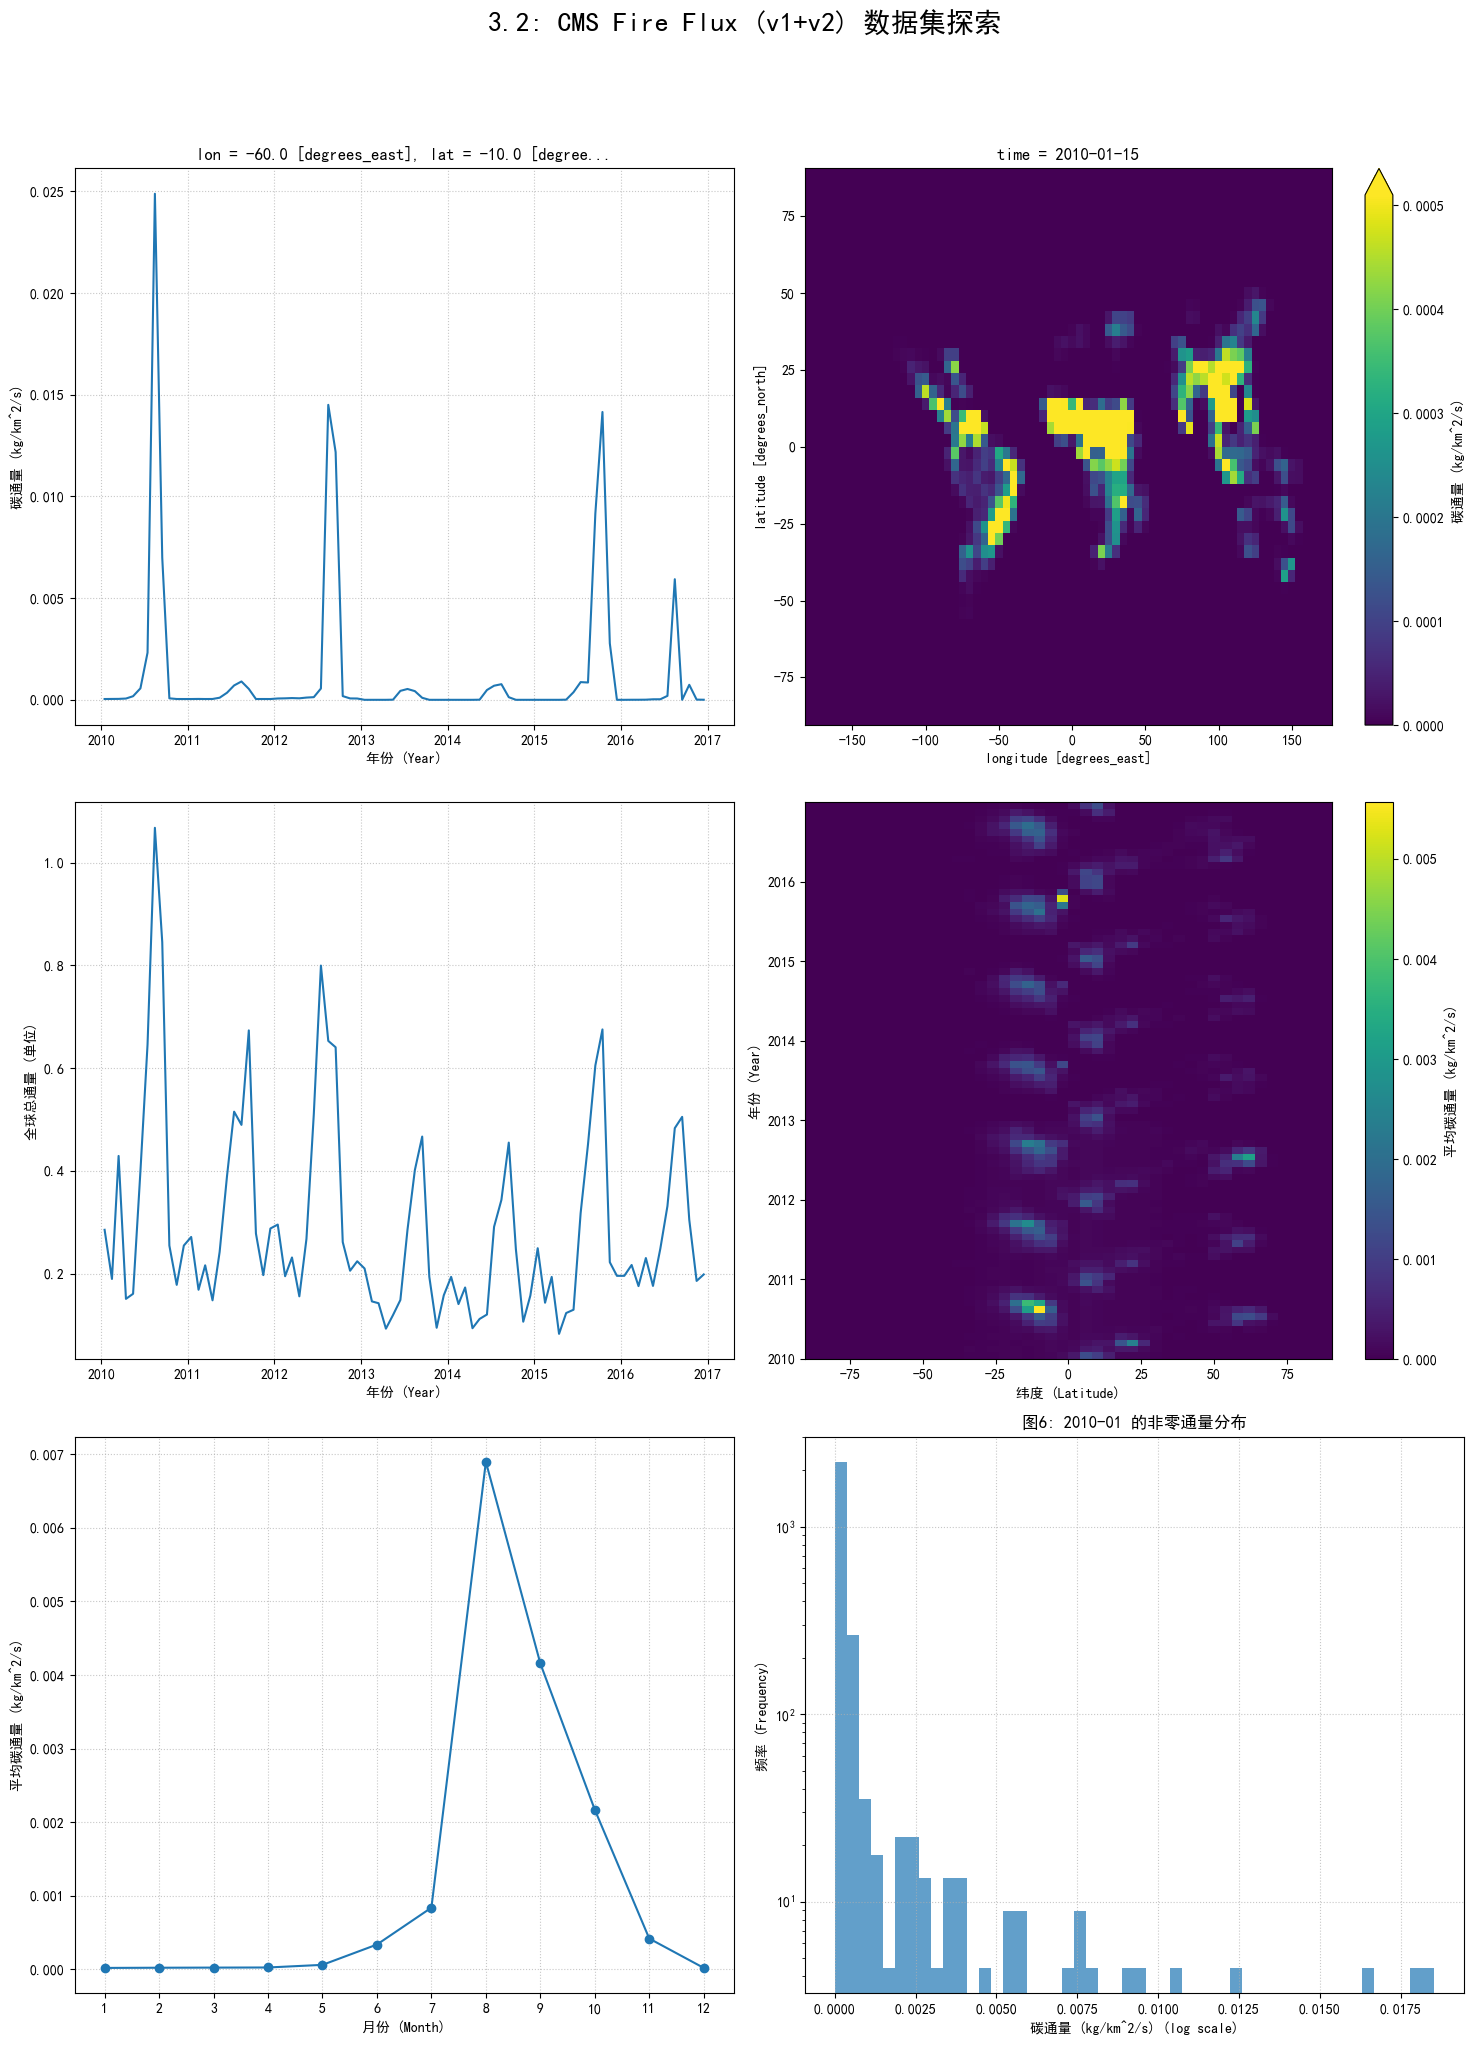

In [12]:
#3.2 至少完成 5 个使用该数据集绘制不同的图表。

print("3.2：绘制至少 5 个不同的图")

# 为了在一个窗口中显示所有6个图，我们创建一个 3x2 的子图网格
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 20))
plt.subplots_adjust(hspace=0.4, wspace=0.3) # 调整子图间距

#图 1：原始时间序列（用于对比）
axes[0, 0].set_title(f"图1: 原始碳通量时间序列 at (lat={lat_point:.2f}, lon={lon_point:.2f})")
flux_ts.plot(ax=axes[0, 0])
axes[0, 0].set_ylabel(f"碳通量 ({ds[VARIABLE_NAME].units})")
axes[0, 0].set_xlabel("年份 (Year)")
axes[0, 0].grid(True, linestyle=':', alpha=0.7)

#图 2：单个时间点的全球（或区域）通量图
# .isel(time=0) 选择第一个时间点 (现在是 2010 年 1 月)
flux_snapshot = ds[VARIABLE_NAME].isel(time=0)
axes[0, 1].set_title(f"图2: {ds.time[0].dt.strftime('%Y-%m').values} 的全球碳通量图")
# xarray 的 2D plot 自动绘制地图
flux_snapshot.plot(ax=axes[0, 1], cbar_kwargs={'label': f"碳通量 ({ds[VARIABLE_NAME].units})"}, robust=True) # robust=True 自动处理异常值

#图 3：全球总通量的时间序列
# 对于通量，我们通常关心总和(sum)而非平均(mean)
global_total_flux = ds[VARIABLE_NAME].sum(dim=['lat', 'lon'])
axes[1, 0].set_title("图3: 全球总碳通量时间序列 (未加权)")
global_total_flux.plot(ax=axes[1, 0])
axes[1, 0].set_ylabel("全球总通量 (单位)")
axes[1, 0].set_xlabel("年份 (Year)")
axes[1, 0].grid(True, linestyle=':', alpha=0.7)

#图 4：纬向平均（Zonal Mean）的时间-纬度图 (Hovmöller 图)
# 在经度(lon)维度上求平均
zonal_mean_flux = ds[VARIABLE_NAME].mean(dim='lon')
axes[1, 1].set_title("图4: 纬向平均碳通量 (纬度 vs. 时间)")
zonal_mean_flux.plot(ax=axes[1, 1], cbar_kwargs={'label': f"平均碳通量 ({ds[VARIABLE_NAME].units})"})
axes[1, 1].set_ylabel("年份 (Year)")
axes[1, 1].set_xlabel("纬度 (Latitude)")

#图 5：特定地点的 12 个月气候态
# 使用 3.1 中计算的 climatology 变量
axes[2, 0].set_title(f"图5: 月平均碳通量 (气候态) at (lat={lat_point:.2f}, lon={lon_point:.2f})")
climatology.plot(ax=axes[2, 0], marker='o') # 'o' 标记每个月
axes[2, 0].set_ylabel(f"平均碳通量 ({ds[VARIABLE_NAME].units})")
axes[2, 0].set_xlabel("月份 (Month)")
axes[2, 0].set_xticks(range(1, 13)) # 确保 x 轴显示 1-12
axes[2, 0].grid(True, linestyle=':', alpha=0.7)

#图 6 (附加)：某个时间点通量的直方图（分布图）
# 看看全球（或区域）通量是如何分布的
flux_snapshot_flat = flux_snapshot.values.flatten()
# 移除 NaN 值（如果有的话）
flux_snapshot_flat = flux_snapshot_flat[~np.isnan(flux_snapshot_flat)]
# 过滤掉 0 值，以便更好地查看非零通量的分布
flux_snapshot_flat_nonzero = flux_snapshot_flat[flux_snapshot_flat > 0]
axes[2, 1].set_title(f"图6: {ds.time[0].dt.strftime('%Y-%m').values} 的非零通量分布")
if len(flux_snapshot_flat_nonzero) > 0:
    axes[2, 1].hist(flux_snapshot_flat_nonzero, bins=50, density=True, alpha=0.7, log=True) # 使用对数y轴
    axes[2, 1].set_xlabel(f"碳通量 ({ds[VARIABLE_NAME].units}) (log scale)")
    axes[2, 1].set_ylabel("频率 (Frequency)")
else:
    axes[2, 1].text(0.5, 0.5, "此时间点无非零通量", horizontalalignment='center', verticalalignment='center')
axes[2, 1].grid(True, linestyle=':', alpha=0.7)


# 保存包含所有 6 个图的大图
plt.suptitle("3.2: CMS Fire Flux (v1+v2) 数据集探索", fontsize=20, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98]) # 调整布局以适应大标题
plt.savefig("task_3.2_multi_flux_plots_2010-2016.png")
print("3.2 图像已保存为 'task_3.2_multi_flux_plots_2010-2016.png'")

# plt.show() # 如果希望立即显示所有图像，请取消本行注释